In [85]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import datetime
import itertools
from datetimerange import DateTimeRange
import pickle
import json
import sqlalchemy
from sqlalchemy.sql import text
import matplotlib.ticker as mtick

In [3]:
os.chdir('/home/candela/Documents/greeneHill/membershipReportsCIVI')

In [2]:
sql = '''
WITH trial_conversions AS (
select cast(JSON_EXTRACT(latest_trial2, '$.start_dt') as date) trial_date, cast(start_dt as date) status_date, 
datediff(cast(start_dt as date), cast(JSON_EXTRACT(latest_trial2, '$.start_dt') as date)) as date_difference,
email, type_clean
from mem_type
where (type_clean not like '%%trial%%' AND type_clean not like '%%bushwick%%' AND type_clean not like '%%park%%')
AND cast(JSON_EXTRACT(latest_trial2, '$.start_dt')as date) is not null),
all_trials AS (
select cast(start_dt as date) status_date, email, type_clean
from mem_type
where type_clean like '%%trial%%'),
conversion_agg AS (
select date_format(trial_date, '%%Y-%%m') as month, count(distinct email) as converted_cnt
from trial_conversions 
group by 1),
all_agg AS (
select date_format(status_date, '%%Y-%%m') as month, count(distinct email) as trials_cnt
from all_trials
group by 1)
select all_agg.month, sum(converted_cnt) converted_cnt, sum(trials_cnt) trials_cnt
from conversion_agg
RIGHT JOIN all_agg
ON conversion_agg.month = all_agg.month
group by 1
order by 1 desc;
'''


In [22]:
user = 'root'
password = 'baeldung'
host = '172.17.0.2'
port = 3306
database = 'membership'

url="mysql+pymysql://{0}:{1}@{2}:{3}/{4}".format(user, password, host, port, database)

engine = sqlalchemy.create_engine(url)
#, connect_args={'options': '-csearch_path=schema_name'}, isolation_level="AUTOCOMMIT"


In [42]:

with engine.connect() as conn:
    df = pd.read_sql(sql, con = conn)

In [8]:
#TODO
#convert month field to datetime
#replace NaN with 0
#plot the data as two vertical bars, then later the conversion % as a time series line plot

In [45]:
print(df.dtypes) 
df.tail()

month                    object
converted_cnt           float64
trials_cnt              float64
month_norm       datetime64[ns]
dtype: object


,month,converted_cnt,trials_cnt,month_norm
32,2020-10,8.0,62.0,2020-10-01
33,2020-09,16.0,76.0,2020-09-01
34,2020-08,30.0,92.0,2020-08-01
35,2020-07,8.0,61.0,2020-07-01
36,2020-06,1.0,5.0,2020-06-01


In [81]:
df.head()

,month,converted_cnt,trials_cnt,month_norm,conversion_ratio
0,2023-06,0.0,47.0,2023-06-01,0.000000
1,2023-05,0.0,43.0,2023-05-01,0.000000
2,2023-04,1.0,37.0,2023-04-01,0.027027
3,2023-03,1.0,47.0,2023-03-01,0.021277
4,2023-02,3.0,49.0,2023-02-01,0.061224


In [44]:
df = df.fillna(0)
df['month_norm'] = pd.to_datetime(df['month']).dt.normalize()

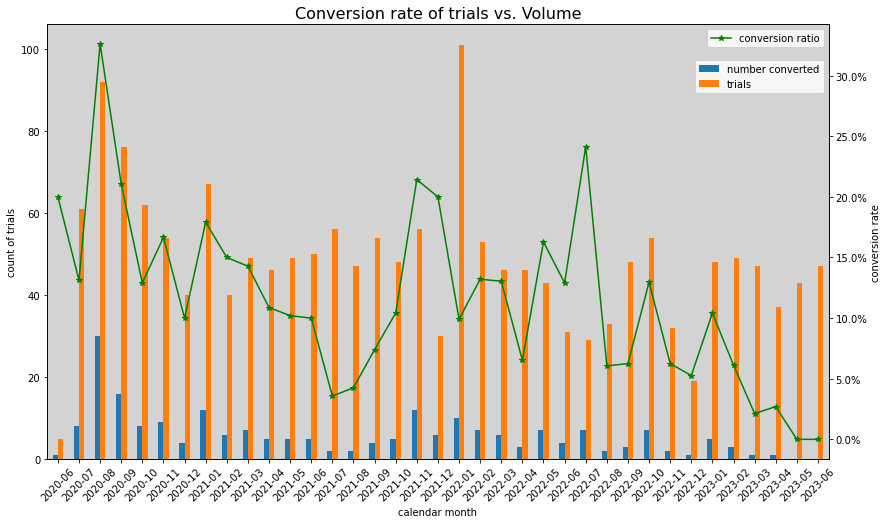

In [107]:
df['conversion_ratio'] = df['converted_cnt']/df['trials_cnt']
fig,ax1 = plt.subplots()
df.sort_values('month', ascending = True).plot(x = "month", y = ["converted_cnt","trials_cnt"], figsize = (10,6), kind = "bar", ax=ax1)
ax1.set_ylabel("count of trials")
ax1.set_xlabel("calendar month")
ax1.legend(bbox_to_anchor = (1,.93),labels = ['number converted','trials'])
ax1.set_facecolor("lightgrey")

ax2=ax1.twinx()
df.sort_values('month', ascending = True).plot(x = "month", y = "conversion_ratio", figsize = (14,8), kind = "line", marker = "*", ax=ax2, color = "green")
ax2.set_ylabel("conversion rate")
ax2.legend(labels = ['conversion ratio'])
ax1.set_xticklabels(df['month'].sort_values(ascending = True),rotation = 45)
ax1.set_title("Conversion rate of trials vs. Volume", fontsize = 16)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()